In [62]:
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import datetime as dt
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
import plotly.graph_objects as go

from scipy.optimize import leastsq
from scipy.optimize import curve_fit

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [63]:
#git status
#git add .
#git commit -m "comment"
#git push

#git pull
#:q (vim's quit)
#:w (vim's save)
#:wq (save & quit)

# Load Data

In [64]:
df= pd.DataFrame()
df= pd.read_csv('http://covidtracking.com/api/states/daily.csv')
df.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200417,AK,309.0,9141.0,NaN,NaN,36.0,NaN,NaN,NaN,...,36.0,9450.0,9450.0,9450.0,2,0.0,1.0,706.0,9.0,715.0
1,20200417,AL,4530.0,33318.0,NaN,NaN,594.0,NaN,247.0,NaN,...,594.0,37848.0,37848.0,37848.0,1,11.0,41.0,1272.0,185.0,1457.0
2,20200417,AR,1695.0,21799.0,NaN,83.0,NaN,NaN,NaN,21.0,...,NaN,23494.0,23494.0,23494.0,5,0.0,0.0,744.0,75.0,819.0
3,20200417,AS,0.0,3.0,17.0,NaN,NaN,NaN,NaN,NaN,...,NaN,20.0,3.0,3.0,60,0.0,0.0,0.0,0.0,0.0
4,20200417,AZ,4507.0,44723.0,NaN,566.0,NaN,285.0,NaN,178.0,...,NaN,49230.0,49230.0,49230.0,4,19.0,0.0,1559.0,273.0,1832.0


# Overview by State

In [65]:
def latest_by_state(df, action_index= 0):
    df_latest= slice_latest(df)
    plot_by_state(df_latest, action_index)

In [66]:
def slice_latest(df):
    df_latest= df.head(56).copy()
    df_latest['total_pos_rate']= df_latest['positive']/df_latest['total']*100
    df_latest['daily_pos_rate']= df_latest['positiveIncrease']/df_latest['totalTestResultsIncrease']*100
    df_latest['date']= pd.to_datetime(df_latest['dateChecked'].str.slice(0, 10, 1), format= '%Y-%m-%d')
    df_latest['positive']= df_latest['positive'].fillna(0)
    df_latest['positive']= df_latest['positive'].round(0).astype(int)
    
    return df_latest

In [67]:
def plot_by_state(df, action_index):
    # If action_index == 0, plot test positive rate by state
    # If action_index == 1, plot positive cases by state
    
    data= {'variable': ['total_pos_rate', 'positive'],
           'plot_title': ['Total Test Positive Rate', 'Total Positive Cases'],
           'legend': ['Test Positive Rate (%)', 'Positive Cases']}
    action= pd.DataFrame(data, columns= ['variable', 'plot_title', 'legend'])
    
    for col in df.columns:
        df[col] = df[col].astype(str)

    if action_index == 0:
        df['text']= 'Total positive cases: ' + df['positive'] + '<br>' + 'Total test results: ' + df['totalTestResults']
    if action_index == 1:
        df['text']= 'Total death: ' + df['death']
        
    fig = go.Figure(data= go.Choropleth(
        locations= df['state'], # Spatial coordinates
        z= df[action['variable'][action_index]].astype(float), # Data to be color-coded
        locationmode= 'USA-states', # set of locations match entries in `locations`
        colorscale= 'Reds',
        text= df['text'], # hover text
        marker_line_color= 'white',
        colorbar_title= action['legend'][action_index],
    ))

    fig.update_layout(
        title_text = 'COVID-19 %s by State (updated on %s)' % (action['plot_title'][action_index], df['date'][0]),
        geo_scope='usa', # limite map scope to USA
    )

    fig.show()

# Test Positive Rate Trend by State

In [68]:
def state_trend(df, state, plot= 'pos_rate'):
    df_state= slice_state(df, state)
    if plot == 'pos_rate':
        plot_test_pos_rate(df_state, state)
    if plot == 'case':
        stackplot_state_case(df_state, state)

In [69]:
def slice_state(df, state):
    # Return a slice of df that is related to state
    # Parameter df: raw data from api
    # Precondition: df is a dataframe and contains the state data and all the columns from the raw data
    # Parameter state: state abbreviation (str)
    
    df_state= df.loc[df['state'] == state].copy()
    df_state['total_pos_rate']= df_state['positive']/df_state['total']*100
    df_state['daily_pos_rate']= df_state['positiveIncrease']/df_state['totalTestResultsIncrease']*100
    df_state['date']= pd.to_datetime(df_state['dateChecked'].str.slice(0, 10, 1), format= '%Y-%m-%d')
    #dates= df_state['dateChecked'].str.slice(0,10,1)
    #df_state['date']= [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in dates]
    
    df_state[['positive', 'death', 'recovered']]= df_state[['positive', 'death', 'recovered']].fillna(0)
    df_state['active']= df_state['positive'] - df_state['death'] - df_state['recovered']
    
    df_state.reset_index(inplace= True)
    
    return df_state

In [70]:
def stackplot_state_case(df, state):
    sns.reset_orig()
    date_form= mdates.DateFormatter("%m-%d")
    markers_on= [0, 1, 2] 
    weekday= SU

    # Print recent data points    
    print('Daily new cases for the recent 3 days')
    for a in range(3):
        recoveredIncrease= df.at[a, 'recovered'] - df.at[a+1, 'recovered']
        print('%s new positive cases: %d, new deaths: %d, new recovered: %d' % (
            df.at[a, 'date'].strftime('%Y-%m-%d'), df.at[a, 'positiveIncrease'], 
            df.at[a, 'deathIncrease'], recoveredIncrease))   
        
    sns.set(font_scale= 1.2)
    fig0, ax0= plt.subplots(figsize= (8.4, 5))
    df= df.iloc[::-1]
    x= [item for item in df['date']]
    y1, y2, y3= df['active'], df['death'], df['recovered']
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    pal= [sns.xkcd_rgb['denim blue'], sns.xkcd_rgb['pale red'], sns.xkcd_rgb['medium green']]
    plt.stackplot(x, y1, y2, y3, labels= ['Active', 'Death', 'Recovered'], colors= pal)
    plt.legend(loc= 'upper left')   

    fig0.autofmt_xdate()    
    ax0.xaxis.set_major_formatter(date_form)
    ax0.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday= weekday)) 

    plt.show()

In [71]:
def plot_test_pos_rate(df, state):
    sns.reset_orig()
    date_form= mdates.DateFormatter("%m-%d")
    markers_on= [0, 1, 2] 
    weekday= SU
    
    # Print recent data points
    print('Cumulative test positive rate for the recent 3 days')
    for a in range(3):
        print('%s: %.1f' % (df_state.at[a, 'date'].strftime('%Y-%m-%d'), df_state.at[a, 'total_pos_rate']) + '%')
    
    fig0, ax0= plt.subplots(figsize= (8.4, 5))
    plt.plot(df['date'], df['total_pos_rate'], color= 'tab:blue', marker= 'o', markevery= markers_on)
    ax0.fmt_xdata= date_form # mdates.DateFormatter('%m-%d')
    ax0.grid()
    ax0.set(ylabel= 'Cumulative Test Positive Rate (%)',
           title= state + ' State COVID-19 Test Positive Rate')
    fig0.autofmt_xdate()    
    ax0.xaxis.set_major_formatter(date_form)
    ax0.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday= weekday))
    
    
    fig1, ax2= plt.subplots(figsize= (8, 5))
    color= 'tab:red'
    ax2.set(xlabel= 'Date')
    ax2.set_ylabel('Daily Test Positive Rate (%)', color= color)
    #ax2.plot(df['date'], df['positiveIncrease'], color= color, marker= 'o', markevery= markers_on)
    ax2.plot(df['date'], df['daily_pos_rate'], color= color, marker= 'o', markevery= markers_on)
    ax2.tick_params(axis= 'y', labelcolor= color)   

    ax3= ax2.twinx()  
    color= 'tab:green'
    ax3.set_ylabel('Daily Test Volume', color= color)  
    ax3.plot(df['date'], df['totalTestResultsIncrease'], color= color, marker= 'o', markevery= markers_on)
    ax3.tick_params(axis='y', labelcolor= color)
    fig1.autofmt_xdate()    
    ax3.xaxis.set_major_formatter(date_form)
    ax3.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday= weekday)) 

    fig1.tight_layout()  # Otherwise the right y-label is slightly clipped
    plt.show()
    

# Bass Model Prediction for Cases in NYS

In [72]:
population= pd.read_csv('https://raw.githubusercontent.com/eestanleyland/COVID-19-Test-Positive-Rate/master/data/nst-est2019-alldata.csv')
population= population[['NAME', 'POPESTIMATE2019']].copy()

list= ['United States', 'Northeast Region', 'Midwest Region', 'South Region', 'West Region', 
       'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'District of Columbia', 'FL', 'GA', 
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 
       'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 
       'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'Puerto Rico']

population['state']= list

In [75]:
def state_model(df, state, bass_df= False):
    # If bass_df == True:
    #     Returns a dataframe contains state's actual data and modeled data and varfinal[M,p,q]
    # If bass_df == False (default):
    #     Print M, p, q and plot the actual modeled data
    
    df_state= slice_state(df, state)
    state_pop= int(population['POPESTIMATE2019'].loc[population.state == state])

    df_Y= df_state[['date', 'positiveIncrease', 'positive']].iloc[::-1].fillna(0)
    df_Y.reset_index(inplace= True)

    if state == 'NY':
        threshold= 500
    else:
        threshold= 10

    day= 0
    daily_increase= 0
    while daily_increase < threshold:
        day+= 1
        daily_increase= df_Y.at[day, 'positiveIncrease']

    df_Y= df_Y[day:].copy()
    df_Y.reset_index(inplace= True)
    df_Y['t']= pd.Series(range(1, len(df_Y['date'])+1))

    Y= df_Y['positiveIncrease']
    t= df_Y['t']

    # Cumulative positive cases
    c_Y= df_Y['positive']

    # initial variables(M, P & Q), estimate 20% of the population in NYS will be infected
    vars= [state_pop*0.015, 0.03, 0.38]

    # residual (error) function
    def residual(vars, t, Y):
        M= vars[0]
        P= vars[1]
        Q= vars[2]
        Bass= M * (((P+Q)**2/P)*np.exp(-(P+Q)*t))/(1+(Q/P)*np.exp(-(P+Q)*t))**2 
        return (Bass - Y)
 
    # non linear least square fitting
    varfinal, success = leastsq(residual, vars, args=(t, Y))

    # estimated coefficients
    m= varfinal[0]
    p= varfinal[1]
    q= varfinal[2]

    print('M (estimated cumulative cases): %0.3e, p: %0.3e, q= %0.3e' % (m, p, q))

    # Extend date range for prediction
    pred_days= 41
    times = pd.date_range(df_Y.at[len(df_Y)-1, 'date'], periods= pred_days, freq= '1D')
    df_times = pd.DataFrame({'date': times[1:]})
    df_Y= df_Y.append(df_times, ignore_index = True, sort= False)
    df_Y['t']= pd.Series(range(1, len(df_Y['date'])+1))

    # model with time interpolation
    tp= df_Y['t']
    cofactor= np.exp(-(p+q)*tp)
    df_Y['positiveIncrease_pdf']= m*(((p+q)**2/p)*cofactor)/(1+(q/p)*cofactor)**2

    if bass_df == True:
        return df_Y, varfinal
    
    if bass_df == False:    
        # daily new case plot
        #plt.plot(df_Y['date'], df_Y['positiveIncrease_pdf'], df_Y['date'], df_Y['positiveIncrease'])
        #plt.title('positiveIncrease_pdf')
        #plt.legend(['Model', 'Actual'])
        #plt.show()

        sns.reset_orig()
        date_form= mdates.DateFormatter("%m-%d")
        weekday= SU
        
        fig0, ax0= plt.subplots(figsize=(8.4, 5))
        plt.plot(df_Y['date'], df_Y['positiveIncrease_pdf'], df_Y['date'], df_Y['positiveIncrease'])
        ax0.fmt_xdata= date_form # mdates.DateFormatter('%m-%d')
        ax0.grid()
        ax0.legend(['Model', 'Actual'])
        ax0.set(ylabel= 'Positive Cases', title= state + ' State COVID-19 Daily New Cases Prediction')
        fig0.autofmt_xdate()    
        ax0.xaxis.set_major_formatter(date_form)
        ax0.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday= weekday))
        plt.show()

        # Cumulative positive cases (cdf)
        df_Y['positive_cdf'] = m*(1-cofactor)/(1+(q/p)*cofactor)
        #plt.plot(tp, positive_cdf, t, c_Y)
        #plt.title('Positive Cases cdf')
        #plt.legend(['Model', 'Actual'])
        #plt.show()

        fig1, ax1= plt.subplots(figsize=(8.4, 5))
        plt.plot(df_Y['date'], df_Y['positive_cdf'], df_Y['date'], df_Y['positive'])
        ax1.fmt_xdata= date_form # mdates.DateFormatter('%m-%d')
        ax1.grid()
        ax1.legend(['Model', 'Actual'])
        ax1.set(ylabel= 'Cumulative Positive Cases', title= state + ' State COVID-19 Cumulative Cases Prediction')
        fig1.autofmt_xdate()    
        ax1.xaxis.set_major_formatter(date_form)
        ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday= weekday))
        plt.show()

# User Interface

M (estimated cumulative cases): 3.040e+05, p: 7.153e-03, q= 1.168e-01


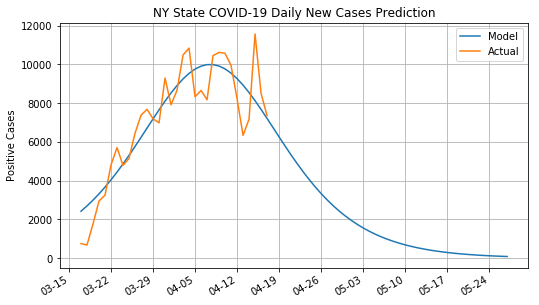

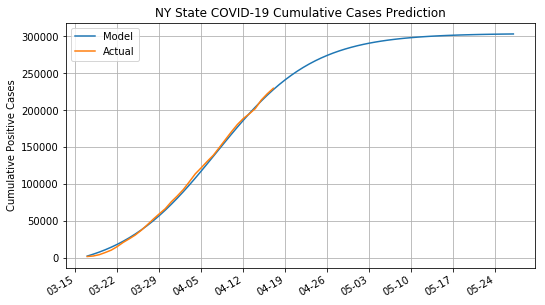

TypeError: 'NoneType' object is not iterable

In [76]:
bass_df, varfinal= state_model(df, 'NY')
bass_df.head(40)

Daily new cases for the recent 3 days
2020-04-12 new positive cases: 8236, new deaths: 758, new recovered: 1862
2020-04-11 new positive cases: 9946, new deaths: 783, new recovered: 1776
2020-04-10 new positive cases: 10575, new deaths: 777, new recovered: 1952


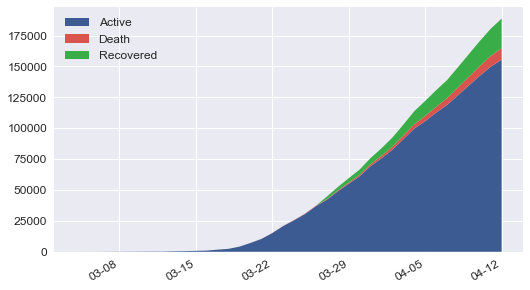

In [154]:
state_trend(df, 'NY', plot= 'case')

Cumulative test positive rate for the recent 3 days
2020-04-15: 40.6%
2020-04-14: 40.5%
2020-04-13: 40.8%


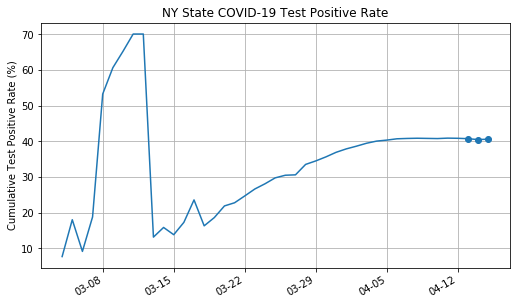

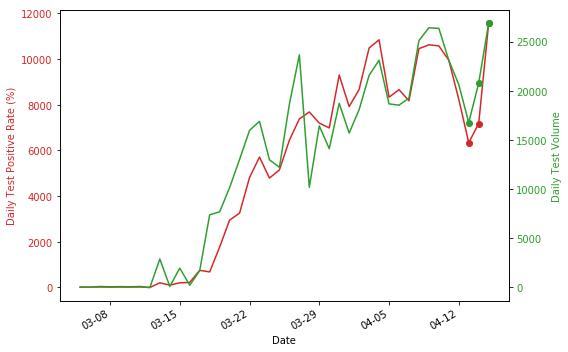

In [46]:
state_trend(df, 'NY', plot= 'pos_rate')

Cumulative test positive rate for the recent 3 days
2020-04-12: 40.9%
2020-04-11: 40.9%
2020-04-10: 40.8%


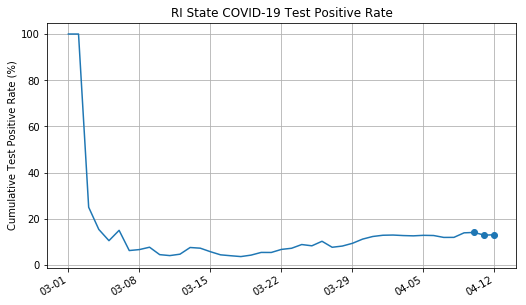

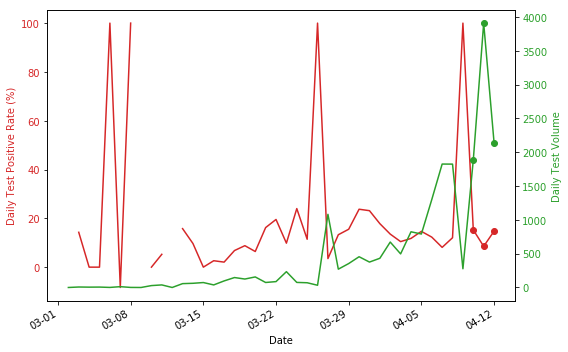

In [134]:
state_trend(df, 'RI', plot= 'pos_rate')

In [132]:
latest_by_state(df)